In [1]:
COUNT = 100
TRAIN = '/kaggle/input/english-alphabets-28-and-64-px-handwritten-for-ocr/a_z/Augmentation 64 X 64/'

We want to use image embeddings for both EDA and classification, so let's add some code that will get image embeddings using ResNeXt with no fine tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 163MB/s]


Now let's load up a sample of our data, including image embeddings and thumbnails.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < COUNT]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 100 rows of e_101  in 0:00:15.072121
encoded 100 rows of q_113  in 0:00:14.429527
encoded 100 rows of n_110  in 0:00:14.533989
encoded 100 rows of x_120  in 0:00:14.402897
encoded 100 rows of k_107  in 0:00:14.093463
encoded 100 rows of s_115  in 0:00:13.951721
encoded 100 rows of f_102  in 0:00:14.037638
encoded 100 rows of m_109  in 0:00:14.396914
encoded 100 rows of d_100  in 0:00:14.102550
encoded 100 rows of w_119  in 0:00:14.885442
encoded 100 rows of h_104  in 0:00:14.732855
encoded 100 rows of r_114  in 0:00:14.633222
encoded 100 rows of y_121  in 0:00:14.610585
encoded 100 rows of p_112  in 0:00:14.519571
encoded 100 rows of l_108  in 0:00:14.801111
encoded 100 rows of i_105  in 0:00:15.628169
encoded 100 rows of t_116  in 0:00:14.832765
encoded 100 rows of a_97  in 0:00:14.462743
encoded 100 rows of u_117  in 0:00:14.234905
encoded 100 rows of j_106  in 0:00:14.420339
encoded 100 rows of b_98  in 0:00:14.405462
encoded 100 rows of v_118  in 0:00:14.501236
encoded 100 

What are the dimensions of our DataFrame?

In [4]:
train_df.shape

(2300, 4)

That's odd. We should have 26 x COUNT rows. How many unique letters do we have?

In [5]:
train_df['tag'].nunique()

23

Okay. What's missing?

In [6]:
numbers = list(range(97,123))
letters = [chr(number) for number in numbers]
expected = set([f'{letters[index]}_{numbers[index]}' for index in range(26)])
actual = set(train_df['tag'].sort_values().unique().tolist())
[item for item in expected if item not in actual]

['z_122', 'o_111', 'c_99']

Our classes are balanced by construction, because of the way we took our sample. If we expand to the full dataset, that may change.

In [7]:
train_df['tag'].value_counts(normalize=True).to_frame().T

tag,e_101,y_121,v_118,b_98,j_106,u_117,a_97,t_116,i_105,l_108,...,h_104,w_119,d_100,m_109,f_102,s_115,k_107,x_120,n_110,g_103
proportion,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,...,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478,0.043478


Now let's get x/y coordinates for our data based on the image embeddings.

In [8]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2300 samples in 0.017s...
[t-SNE] Computed neighbors for 2300 samples in 0.568s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2300
[t-SNE] Computed conditional probabilities for sample 2000 / 2300
[t-SNE] Computed conditional probabilities for sample 2300 / 2300
[t-SNE] Mean sigma: 2.496884
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.732399
[t-SNE] KL divergence after 1000 iterations: 1.364048


Now we are ready to plot.

In [9]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: lower-case letters (a-z)', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=8, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? We see that we have some tight, isolated clusters (a, e) some easy to understand conflations that are mingled (g, y) and what appears to be some mislabeled data (s, w). We should probably have moderate expectations regarding model accuracy, because some of our training data is a mess. Let's build a model and find out.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=5000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 1101 iterations
accuracy: 0.9461
f1: 0.9455
              precision    recall  f1-score   support

        a_97       1.00      1.00      1.00        25
        b_98       0.86      1.00      0.93        25
       d_100       0.95      0.84      0.89        25
       e_101       0.96      1.00      0.98        25
       f_102       0.91      0.80      0.85        25
       g_103       0.96      0.88      0.92        25
       h_104       0.91      0.84      0.87        25
       i_105       0.96      1.00      0.98        25
       j_106       0.96      0.88      0.92        25
       k_107       0.96      1.00      0.98        25
       l_108       0.89      1.00      0.94        25
       m_109       1.00      1.00      1.00        25
       n_110       0.88      0.92      0.90        25
       p_112       0.93      1.00      0.96        25
       q_113       0.96      0.92      0.94        25
       r_114       0.92      0.88      0.90        25
       s_115       0.85 

This is puzzling; our f1 is much higher than we might have expected based on the EDA. Our model is probably not as accurate as our f1 suggests, because it is trained on messy and occasionally misleading data.

What do our model probabilities look like?

<Axes: xlabel='probability', ylabel='Count'>

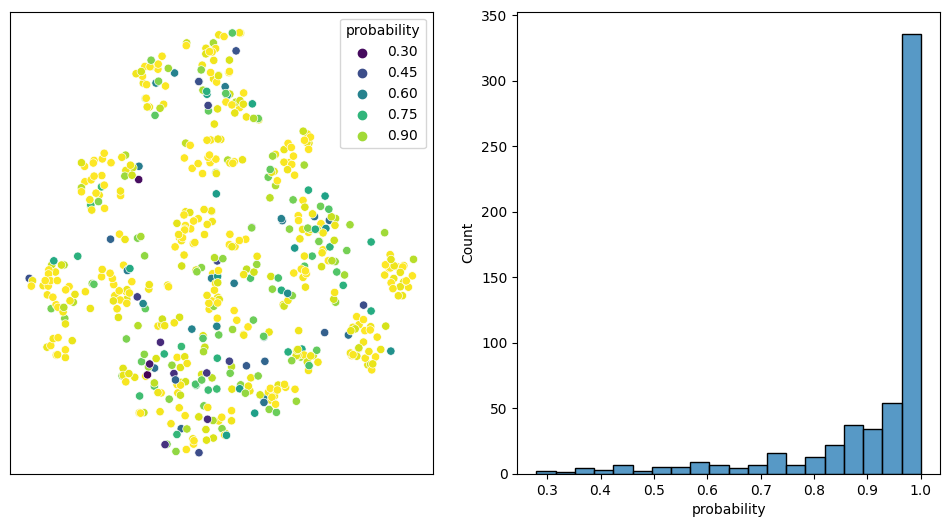

In [11]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Not surprisingly our high model probabilities follow our tight clusters, and our low model probabilities follow the ambiguous/mislabeled cases.